In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)

# ============================================
# Load MAGIC Gamma Telescope Dataset (Local file)
# ============================================
# Your local file name:
local_path = "magic04data.sec"

# Official MAGIC column names (10 numeric features + 1 label)
cols_magic = [
    "fLength","fWidth","fSize","fConc","fConc1",
    "fAsym","fM3Long","fM3Trans","fAlpha","fDist","class"
]

# Try reading as CSV (comma-separated). If that fails, try semicolon or whitespace.
magic_df = None
read_errors = []
for read_kwargs in [
    {"header": None, "names": cols_magic},                 # default (comma)
    {"header": None, "names": cols_magic, "sep": ";"},     # semicolon
    {"header": None, "names": cols_magic, "delim_whitespace": True},  # whitespace
]:
    try:
        magic_df = pd.read_csv(local_path, **read_kwargs)
        break
    except Exception as e:
        read_errors.append(str(e))

if magic_df is None:
    raise RuntimeError(
        f"Failed to read {local_path} with common separators. Errors:\n" +
        "\n".join(read_errors)
    )

print("MAGIC Gamma Telescope Dataset:")
print(f"Shape: {magic_df.shape}")
print(f"\nClass distribution:\n{magic_df['class'].value_counts()}")
print(f"\nFeature statistics:\n{magic_df.drop(columns=['class']).describe()}")

# ============================================
# Preprocessing MAGIC Dataset
# ============================================
# Encode labels: 'g' (gamma) -> +1, 'h' (hadron) -> -1
label_map = {'g': 1, 'h': -1}
magic_df['label'] = magic_df['class'].map(label_map).astype(int)

# Safety check for unseen labels
if magic_df['label'].isna().any():
    unknown = magic_df[magic_df['label'].isna()]['class'].unique()
    raise ValueError(f"Unknown labels encountered during encoding: {unknown}")

# Extract features and labels
feature_cols = [c for c in magic_df.columns if c not in ('class', 'label')]
X_magic = magic_df[feature_cols].to_numpy(dtype=np.float64)
y_magic = magic_df['label'].to_numpy(dtype=np.int64)

# ============================================
# Standardization/Normalize Function
# ============================================
class StandardScalerNP:
    """
    NumPy-only standardizer (z-score): x' = (x - mean) / std.
    Fit on training data; apply to other splits without leakage.
    """
    def __init__(self, eps: float = 1e-12):
        self.mean_ = None
        self.std_ = None
        self.eps = eps

    def fit(self, X: np.ndarray):
        self.mean_ = X.mean(axis=0)
        self.std_ = X.std(axis=0, ddof=0)
        # avoid division by near-zero std
        self.std_ = np.where(self.std_ < self.eps, 1.0, self.std_)
        return self

    def transform(self, X: np.ndarray) -> np.ndarray:
        if self.mean_ is None or self.std_ is None:
            raise RuntimeError("StandardScalerNP must be fit before transform().")
        return (X - self.mean_) / self.std_

    def fit_transform(self, X: np.ndarray) -> np.ndarray:
        return self.fit(X).transform(X)

# ============================================
# Train/Test Split Function (80%/20%)
# ============================================
def train_test_split(X, y, train_ratio=0.8, seed=42):
    """
    Split data into train and test sets.
    """
    np.random.seed(seed)
    n = len(y)
    indices = np.random.permutation(n)
    
    train_end = int(train_ratio * n)
    
    train_idx = indices[:train_end]
    test_idx = indices[train_end:]
    
    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

# ============================================
# Split and Standardize MAGIC Dataset
# ============================================
X_train_magic_raw, X_test_magic_raw, y_train_magic, y_test_magic = train_test_split(
    X_magic, y_magic, train_ratio=0.8, seed=SEED
)

scaler_magic = StandardScalerNP()
X_train_magic = scaler_magic.fit_transform(X_train_magic_raw)
X_test_magic  = scaler_magic.transform(X_test_magic_raw)

print("\n" + "="*50)
print("MAGIC Dataset Split (80/20):")
print(f"Training set: {X_train_magic.shape[0]} samples")
print(f"Test set:     {X_test_magic.shape[0]} samples")

MAGIC Gamma Telescope Dataset:
Shape: (19020, 11)

Class distribution:
class
g    12332
h     6688
Name: count, dtype: int64

Feature statistics:
            fLength        fWidth         fSize         fConc        fConc1  \
count  19020.000000  19020.000000  19020.000000  19020.000000  19020.000000   
mean      53.250154     22.180966      2.825017      0.380327      0.214657   
std       42.364855     18.346056      0.472599      0.182813      0.110511   
min        4.283500      0.000000      1.941300      0.013100      0.000300   
25%       24.336000     11.863800      2.477100      0.235800      0.128475   
50%       37.147700     17.139900      2.739600      0.354150      0.196500   
75%       70.122175     24.739475      3.101600      0.503700      0.285225   
max      334.177000    256.382000      5.323300      0.893000      0.675200   

              fAsym       fM3Long      fM3Trans        fAlpha         fDist  
count  19020.000000  19020.000000  19020.000000  19020.000000  1

In [5]:
# ============================================================
# (2) Implement Kernel Functions
# ============================================================

def linear_kernel(X: np.ndarray, Y: np.ndarray, **kwargs) -> np.ndarray:
    """
    Linear kernel: K(x, y) = x · y
    Shapes:
      X: (n_x, d), Y: (n_y, d) -> K: (n_x, n_y)
    """
    return X @ Y.T

def polynomial_kernel(X: np.ndarray, Y: np.ndarray, degree: int = 3, gamma: float = None, coef0: float = 1.0) -> np.ndarray:
    """
    Polynomial kernel: K(x, y) = (gamma * x · y + coef0)^degree
    Defaults:
      gamma = 1 / d  (d = number of features)
    """
    if gamma is None:
        gamma = 1.0 / X.shape[1]
    return (gamma * (X @ Y.T) + coef0) ** degree

def rbf_kernel(X: np.ndarray, Y: np.ndarray, gamma: float = None) -> np.ndarray:
    """
    RBF (Gaussian) kernel: K(x, y) = exp(-gamma * ||x - y||^2)
    Defaults:
      gamma = 1 / d  (heuristic)
    Efficient computation using expansion of squared norms:
      ||x - y||^2 = ||x||^2 + ||y||^2 - 2 x·y
    """
    if gamma is None:
        gamma = 1.0 / X.shape[1]
    X_norm = np.sum(X**2, axis=1).reshape(-1, 1)     # (n_x, 1)
    Y_norm = np.sum(Y**2, axis=1).reshape(1, -1)     # (1, n_y)
    K = X_norm + Y_norm - 2 * (X @ Y.T)              # pairwise squared distances
    return np.exp(-gamma * K)

def sigmoid_kernel(X: np.ndarray, Y: np.ndarray, gamma: float = None, coef0: float = 0.0) -> np.ndarray:
    """
    Sigmoid kernel: K(x, y) = tanh(gamma * x · y + coef0)
    (Related to neural net activation; not positive semidefinite for all params.)
    Defaults:
      gamma = 1 / d
    """
    if gamma is None:
        gamma = 1.0 / X.shape[1]
    return np.tanh(gamma * (X @ Y.T) + coef0)

# Dispatcher (optional convenience)
def kernel_matrix(X: np.ndarray,
                  Y: np.ndarray,
                  kernel: str = "rbf",
                  **params) -> np.ndarray:
    """
    Compute kernel matrix K(X, Y) for given kernel type and parameters.
    kernel in {"linear", "poly", "polynomial", "rbf", "gaussian", "sigmoid"}.
    """
    k = kernel.lower()
    if k in ("linear",):
        return linear_kernel(X, Y, **params)
    elif k in ("poly", "polynomial"):
        return polynomial_kernel(X, Y, **params)
    elif k in ("rbf", "gaussian"):
        return rbf_kernel(X, Y, **params)
    elif k in ("sigmoid",):
        return sigmoid_kernel(X, Y, **params)
    else:
        raise ValueError(f"Unknown kernel type: {kernel}")

# ============================================================
# Test the kernel functions
# ============================================================
print("Testing kernel functions...")
X_test_k = np.array([[1, 2], [3, 4], [5, 6]])   # shape (3,2)
Y_test_k = np.array([[1, 1], [2, 2]])           # shape (2,2)

# Compute kernels with illustrative parameters
K_lin = kernel_matrix(X_test_k, Y_test_k, kernel="linear")
K_poly = kernel_matrix(X_test_k, Y_test_k, kernel="poly", degree=3, gamma=0.5, coef0=1.0)
K_rbf = kernel_matrix(X_test_k, Y_test_k, kernel="rbf", gamma=0.25)
K_sig = kernel_matrix(X_test_k, Y_test_k, kernel="sigmoid", gamma=0.5, coef0=0.0)

# Print kernel shapes and values
print("\nLinear kernel:")
print(f"kernel shape: {K_lin.shape}")
print(f"kernel values:\n{K_lin}")

print("\nPolynomial kernel (degree=3, gamma=0.5, coef0=1.0):")
print(f"kernel shape: {K_poly.shape}")
print(f"kernel values:\n{K_poly}")

print("\nRBF kernel (gamma=0.25):")
print(f"kernel shape: {K_rbf.shape}")
print(f"kernel values:\n{K_rbf}")

print("\nSigmoid kernel (gamma=0.5, coef0=0.0):")
print(f"kernel shape: {K_sig.shape}")
print(f"kernel values:\n{K_sig}")

Testing kernel functions...

Linear kernel:
kernel shape: (3, 2)
kernel values:
[[ 3  6]
 [ 7 14]
 [11 22]]

Polynomial kernel (degree=3, gamma=0.5, coef0=1.0):
kernel shape: (3, 2)
kernel values:
[[  15.625   64.   ]
 [  91.125  512.   ]
 [ 274.625 1728.   ]]

RBF kernel (gamma=0.25):
kernel shape: (3, 2)
kernel values:
[[7.78800783e-01 7.78800783e-01]
 [3.87742078e-02 2.86504797e-01]
 [3.53575009e-05 1.93045414e-03]]

Sigmoid kernel (gamma=0.5, coef0=0.0):
kernel shape: (3, 2)
kernel values:
[[0.90514825 0.99505475]
 [0.9981779  0.99999834]
 [0.9999666  1.        ]]


Testing DUAL SVM implementation...

Training complete!
Number of support vectors: 560 (93.3%)
Final Training Accuracy: 0.8633 (86.33%)


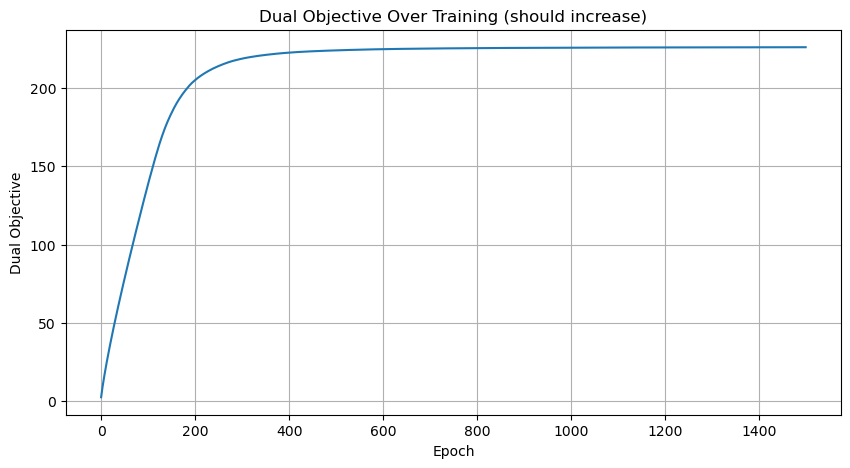


Test accuracy on subset: 0.8331


In [6]:
# ============================================
# (3) DUAL SVM FORMULATION via Projected Gradient Ascent
# ============================================

def dual_objective(alpha: np.ndarray, K: np.ndarray, y: np.ndarray) -> float:
    """
    Dual objective: L(alpha) = sum(alpha) - 0.5 * alpha^T (YKY) alpha
    where (YKY)_{ij} = y_i y_j K_{ij}.
    """
    y = y.astype(np.float64)
    Q = (y[:, None] * y[None, :]) * K  # (n, n)
    return float(alpha.sum() - 0.5 * alpha @ (Q @ alpha))


def dual_gradient(alpha: np.ndarray, K: np.ndarray, y: np.ndarray) -> np.ndarray:
    """
    Gradient of the dual objective w.r.t alpha for ascent:
      grad = 1 - (YKY) alpha
    """
    y = y.astype(np.float64)
    Q = (y[:, None] * y[None, :]) * K  # (n, n)
    return 1.0 - Q @ alpha


def project_onto_constraints(alpha: np.ndarray, y: np.ndarray, C: float) -> np.ndarray:
    """
    Project alpha onto the feasible set:
      0 <= alpha_i <= C, and sum_i alpha_i y_i = 0.
    Strategy:
      1) clip to [0, C]
      2) project onto hyperplane y^T alpha = 0 by removing component along y
      3) clip again and do a small correction on free vars if available
    """
    y = y.astype(np.float64)
    out = np.clip(alpha, 0.0, C)

    # Project onto hyperplane y^T alpha = 0
    yy = float(np.dot(y, y))
    if yy > 0:
        t = float(np.dot(y, out)) / yy
        out = out - t * y

    # Re-clip and attempt a mild correction using free set
    out = np.clip(out, 0.0, C)
    residual = float(np.dot(y, out))
    if abs(residual) > 1e-10:
        free = (out > 1e-10) & (out < C - 1e-10)
        if np.any(free):
            yy_free = float(np.dot(y[free], y[free]))
            if yy_free > 0:
                t2 = residual / yy_free
                out[free] = out[free] - t2 * y[free]
                out = np.clip(out, 0.0, C)
    return out


class SVM:
    """
    Soft-margin SVM in the dual (kernelized) trained via Projected Gradient Ascent.
    - kernel: either a string ("linear", "rbf", "poly", "sigmoid") or a callable K(X, Y).
    - kernel_params: kwargs for the chosen kernel.
    - C: regularization parameter.
    - lr: learning rate for gradient ascent.
    - epochs: number of ascent iterations.
    - tol: early-stopping tolerance on objective improvement.
    - verbose: print progress.
    """
    def __init__(self,
                 kernel="rbf",
                 kernel_params=None,
                 C: float = 1.0,
                 lr: float = 1e-2,
                 epochs: int = 1000,
                 tol: float = 1e-6,
                 verbose: bool = False):
        self.C = float(C)
        self.lr = float(lr)
        self.epochs = int(epochs)
        self.tol = float(tol)
        self.verbose = bool(verbose)

        # Handle kernel
        self.kernel_type = kernel
        self.kernel_params = kernel_params or {}
        if callable(kernel):
            # user supplied function K(X, Y)
            self.kernel = kernel
        else:
            # use dispatcher from Step (2)
            def _kernel(Xa, Xb):
                return kernel_matrix(Xa, Xb, kernel=self.kernel_type, **self.kernel_params)
            self.kernel = _kernel

        # Learned parameters
        self.alpha = None
        self.b = 0.0
        self.X_train = None
        self.y_train = None
        self.loss_history = []

    def fit(self, X: np.ndarray, y: np.ndarray, graph: bool = False):
        """
        Train SVM via dual projected gradient ascent.
        """
        X = np.asarray(X, dtype=np.float64)
        y = np.asarray(y, dtype=np.float64)
        assert set(np.unique(y)).issubset({-1.0, 1.0}), "Labels must be in {-1, +1}."

        n_samples = X.shape[0]
        y_svm = y.copy()

        # Precompute Gram matrix
        K = self.kernel(X, X)  # (n, n)

        # Initialize alphas
        alpha = np.zeros(n_samples, dtype=np.float64)

        best_obj = -np.inf
        no_improve = 0
        for epoch in range(self.epochs):
            # Gradient ascent step
            grad = dual_gradient(alpha, K, y_svm)
            alpha_new = alpha + self.lr * grad

            # Project onto constraints
            alpha_new = project_onto_constraints(alpha_new, y_svm, self.C)

            # Evaluate dual objective
            obj = dual_objective(alpha_new, K, y_svm)
            self.loss_history.append(obj)

            # Accept the step (monotone ascent not strictly required but preferred)
            if obj >= best_obj - 1e-12:
                best_obj = obj
                alpha = alpha_new
                no_improve = 0
            else:
                # optional backoff: small shrink in lr if worsened
                no_improve += 1
                alpha = alpha_new  # still take it; or: alpha = alpha  (keep old)
            
            # Early stop if objective improvement stalls
            if epoch > 10:
                improvement = self.loss_history[-1] - self.loss_history[-11]
                if abs(improvement) < self.tol:
                    if self.verbose:
                        print(f"Early stopping at epoch {epoch}, 10-epoch improvement={improvement:.3e}")
                    break

            if self.verbose and (epoch % max(1, self.epochs // 10) == 0):
                print(f"Epoch {epoch:4d}  Dual Obj: {obj:.6f}  ||grad||={np.linalg.norm(grad):.3e}")

        # Store learned dual variables
        self.alpha = alpha
        self.X_train = X
        self.y_train = y_svm

        # Compute bias b using KKT on free SVs: 0 < alpha_i < C
        alpha_y = self.alpha * self.y_train
        f = K @ alpha_y
        free = (self.alpha > 1e-6) & (self.alpha < self.C - 1e-6)
        if np.any(free):
            self.b = float(np.mean(self.y_train[free] - f[free]))
        else:
            # Fallback: use all support vectors (alpha > 0) median for robustness
            sv = (self.alpha > 1e-6)
            if np.any(sv):
                self.b = float(np.median(self.y_train[sv] - f[sv]))
            else:
                # Degenerate case (no SV found) -> bias 0
                self.b = 0.0

        if graph:
            n_sv = int(np.sum(self.alpha > 1e-6))
            alpha_y = self.alpha * y_svm
            f = K @ alpha_y + self.b
            y_pred = np.sign(f)
            train_acc = np.mean(y_svm == y_pred)
            print(f"\nTraining complete!")
            print(f"Number of support vectors: {n_sv} ({100*n_sv/n_samples:.1f}%)")
            print(f"Final Training Accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")

            plt.figure(figsize=(10, 5))
            plt.plot(self.loss_history)
            plt.xlabel('Epoch')
            plt.ylabel('Dual Objective')
            plt.title('Dual Objective Over Training (should increase)')
            plt.grid(True)
            plt.show()

        return self

    def decision_function(self, X: np.ndarray) -> np.ndarray:
        """
        Signed distance (up to scaling): f(x) = sum_j alpha_j y_j K(x, x_j) + b
        """
        K = self.kernel(X, self.X_train)
        return K @ (self.alpha * self.y_train) + self.b

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Predict class labels in {-1, +1}.
        """
        f = self.decision_function(X)
        return np.where(f >= 0, 1, -1)


def accuracy(y_true, y_pred):
    """Calculate classification accuracy for labels in {-1, +1} (or both in {0,1})."""
    return np.mean(y_true == y_pred)


# ============================================
# Test the DUAL SVM implementation
# ============================================
print("Testing DUAL SVM implementation...")
X_small = X_train_magic[:600]
y_small = y_train_magic[:600]

# TODO: Create and train SVM on small subset
svm_test = SVM(kernel="rbf",
               kernel_params={"gamma": 1.0 / X_small.shape[1]},
               C=1.0,
               lr=5e-3,
               epochs=1500,
               tol=1e-5,
               verbose=False)

svm_test.fit(X_small, y_small, graph=True)

# Predict on test set
y_pred = svm_test.predict(X_test_magic)

# Prefer comparing in {-1, +1} directly:
test_acc = accuracy(y_test_magic, y_pred)
print(f"\nTest accuracy on subset: {test_acc:.4f}")

# If you specifically need {0,1}, convert BOTH:
# y_pred_binary = (y_pred == 1).astype(int)
# y_test_binary = (y_test_magic == 1).astype(int)
# test_acc_bin =# test_acc_bin = accuracy(y_test_binary, y_pred_binary)


In [ ]:
import time
import itertools

# ============================================
# (4) Hyperparameter Tuning via Grid Search
# ============================================

# TODO: Define hyperparameter search space (lightweight for speed)
search_space = {
    "kernel": ["rbf"],               # Stick to RBF for MAGIC
    "C": [0.5, 1.0, 2.0],           # Regularization
    "lr": [5e-3],                   # Fixed learning rate (fast & stable)
    "epochs": [800],                # Fewer epochs to keep it snappy
    # RBF gamma around 1/d; try a couple of values
    "gamma": [1.0 / X_train_magic.shape[1], 0.5 / X_train_magic.shape[1]]
}

def grid_search(X_train: np.ndarray,
                y_train: np.ndarray,
                X_eval: np.ndarray,
                y_eval: np.ndarray,
                search_space: dict,
                verbose: bool = True,
                graph_each: bool = False):
    """
    Exhaustive grid search over the provided search_space.
    Trains on (X_train, y_train) and evaluates on (X_eval, y_eval).

    Returns:
    - best_model: trained SVM instance with best params
    - best_params: dict of best parameters (includes kernel-specific params like 'gamma')
    - best_score: accuracy on evaluation set
    - results_df: pandas DataFrame with all tried configurations and their eval scores
    """
    keys = list(search_space.keys())
    values_product = list(itertools.product(*[search_space[k] for k in keys]))

    results = []
    best_score = -np.inf
    best_model = None
    best_params = None

    total = len(values_product)
    start_all = time.time()

    for idx, combo in enumerate(values_product, start=1):
        params = dict(zip(keys, combo))
        kernel_type = params.get("kernel", "rbf")
        C = float(params.get("C", 1.0))
        lr = float(params.get("lr", 1e-2))
        epochs = int(params.get("epochs", 1000))

        # Build kernel params based on kernel type
        kernel_params = {}
        if kernel_type in ("rbf", "gaussian"):
            gamma_val = float(params.get("gamma", 1.0 / X_train.shape[1]))
            kernel_params["gamma"] = gamma_val
        elif kernel_type in ("poly", "polynomial"):
            gamma_val = float(params.get("gamma", 1.0 / X_train.shape[1]))
            kernel_params["gamma"] = gamma_val
            kernel_params["degree"] = int(params.get("degree", 3))
            kernel_params["coef0"] = float(params.get("coef0", 1.0))
        elif kernel_type in ("sigmoid",):
            gamma_val = float(params.get("gamma", 1.0 / X_train.shape[1]))
            kernel_params["gamma"] = gamma_val
            kernel_params["coef0"] = float(params.get("coef0", 0.0))
        # linear: no kernel params

        if verbose:
            print(f"[{idx}/{total}] kernel={kernel_type}, C={C}, lr={lr}, epochs={epochs}, "
                  f"kernel_params={kernel_params}")

        # Train model
        t0 = time.time()
        svm = SVM(kernel=kernel_type,
                  kernel_params=kernel_params,
                  C=C,
                  lr=lr,
                  epochs=epochs,
                  tol=1e-5,
                  verbose=False)
        svm.fit(X_train, y_train, graph=graph_each)
        train_time = time.time() - t0

        # Evaluate
        y_pred_eval = svm.predict(X_eval)
        score = accuracy(y_eval, y_pred_eval)

        # Store results (flatten kernel_params with 'k_' prefix)
        row = {
            "kernel": kernel_type,
            "C": C,
            "lr": lr,
            "epochs": epochs,
            "score_eval": float(score),
            "train_time_sec": train_time,
            **{f"k_{k}": v for k, v in kernel_params.items()}
        }
        results.append(row)

        # Track best
        if score > best_score:
            best_score = score
            best_model = svm
            best_params = {"kernel": kernel_type, "C": C, "lr": lr, "epochs": epochs, **kernel_params}
            if verbose:
                print(f"  -> New best eval accuracy: {best_score:.4f} with {best_params}")

    elapsed = time.time() - start_all
    results_df = pd.DataFrame(results).sort_values(by="score_eval", ascending=False).reset_index(drop=True)

    if verbose:
        print(f"\nGrid search completed in {elapsed:.2f}s for {total} configurations.")
        print("Top configurations:")
        print(results_df.head(5))

    return best_model, best_params, best_score, results_df

# ============================================
# Fast example usage on MAGIC (subset tuning + full retrain)
# ============================================

# Use a smaller subset for tuning to speed up
X_tune = X_train_magic[:2000]
y_tune = y_train_magic[:2000]

best_model, best_params, best_score, results_df = grid_search(
    X_tune, y_tune,
    X_test_magic, y_test_magic,
    search_space=search_space,
    verbose=True,
    graph_each=False
)

print(f"\nBEST EVAL ACCURACY (subset tuning): {best_score:.4f}")
print(f"BEST PARAMS: {best_params}")

# Retrain best model on the full training set with more epochs
final_svm = SVM(kernel=best_params["kernel"],
                kernel_params={k: v for k, v in best_params.items() if k in ("gamma", "degree", "coef0")},
                C=best_params["C"],
                lr=best_params["lr"],
                epochs=2000,
                tol=1e-5,
                verbose=False)

final_svm.fit(X_train_magic, y_train_magic, graph=True)
y_final_pred = final_svm.predict(X_test_magic)
final_acc = accuracy(y_test_magic, y_final_pred)


[1/6] kernel=rbf, C=0.5, lr=0.005, epochs=800, kernel_params={'gamma': 0.1}
  -> New best eval accuracy: 0.8304 with {'kernel': 'rbf', 'C': 0.5, 'lr': 0.005, 'epochs': 800, 'gamma': 0.1}
[2/6] kernel=rbf, C=0.5, lr=0.005, epochs=800, kernel_params={'gamma': 0.05}
[3/6] kernel=rbf, C=1.0, lr=0.005, epochs=800, kernel_params={'gamma': 0.1}
  -> New best eval accuracy: 0.8386 with {'kernel': 'rbf', 'C': 1.0, 'lr': 0.005, 'epochs': 800, 'gamma': 0.1}
[4/6] kernel=rbf, C=1.0, lr=0.005, epochs=800, kernel_params={'gamma': 0.05}
[5/6] kernel=rbf, C=2.0, lr=0.005, epochs=800, kernel_params={'gamma': 0.1}
  -> New best eval accuracy: 0.8454 with {'kernel': 'rbf', 'C': 2.0, 'lr': 0.005, 'epochs': 800, 'gamma': 0.1}
[6/6] kernel=rbf, C=2.0, lr=0.005, epochs=800, kernel_params={'gamma': 0.05}

Grid search completed in 294.55s for 6 configurations.
Top configurations:
  kernel    C     lr  epochs  score_eval  train_time_sec  k_gamma
0    rbf  2.0  0.005     800    0.845426       48.098380     0.10


MAGIC DATASET - Hyperparameter Tuning
VISUALIZATION - Training Loss Curve


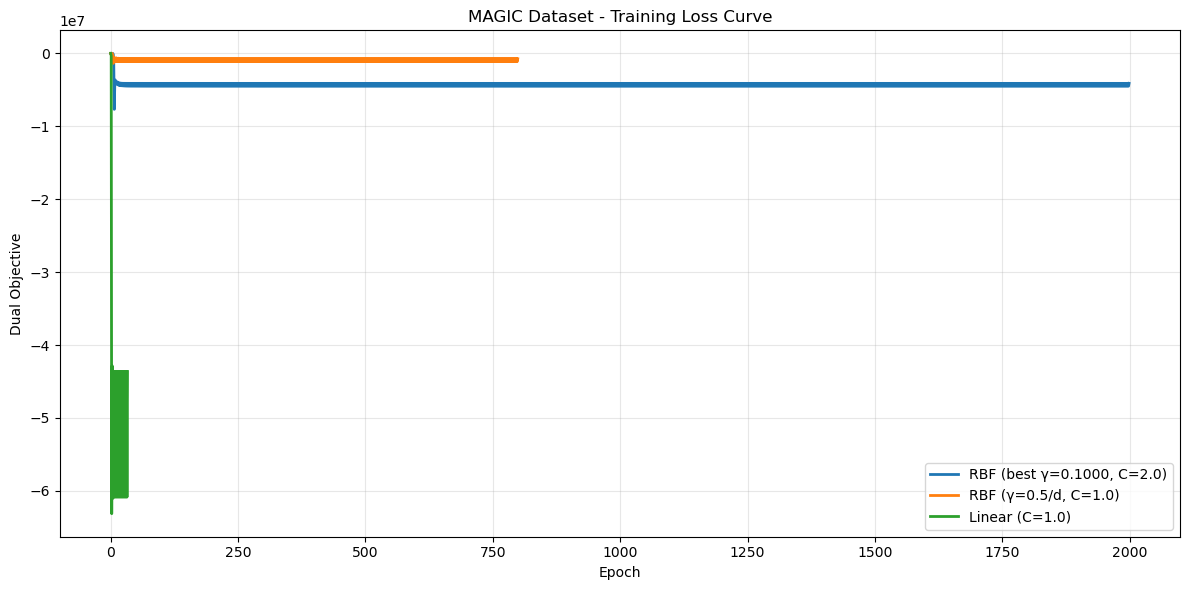

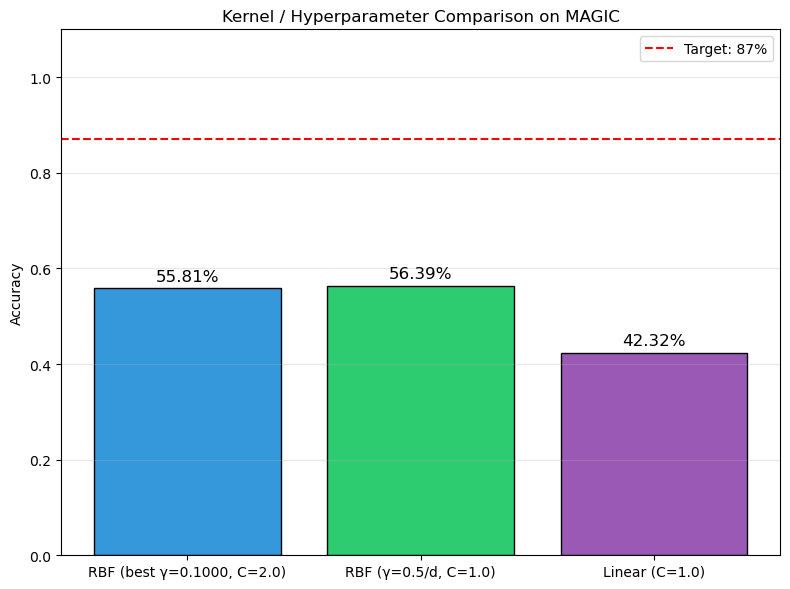

RBF (best γ=0.1000, C=2.0) -> Test Accuracy: 0.5581
RBF (γ=0.5/d, C=1.0)      -> Test Accuracy: 0.5639
Linear (C=1.0)            -> Test Accuracy: 0.4232


In [11]:
def plot_loss_comparison(loss_histories, labels):
    """
    Plot multiple loss curves for comparison.
    """
    plt.figure(figsize=(12, 6))
    for loss_history, label in zip(loss_histories, labels):
        plt.plot(loss_history, label=label, linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Dual Objective')
    plt.title("MAGIC Dataset - Training Loss Curve")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_accuracy_comparison(accuracies, model_names):
    """
    Bar chart comparing accuracies of different models.
    """
    plt.figure(figsize=(8, 6))
    # auto-extend colors if more than two models
    base_colors = ['#3498db', '#2ecc71', '#9b59b6', '#e67e22', '#1abc9c']
    colors = (base_colors * ((len(model_names) // len(base_colors)) + 1))[:len(model_names)]
    bars = plt.bar(model_names, accuracies, color=colors, edgecolor='black')
    
    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                 f'{acc:.2%}', ha='center', va='bottom', fontsize=12)
    
    plt.ylim(0, 1.1)
    plt.ylabel('Accuracy')
    plt.title('Kernel / Hyperparameter Comparison on MAGIC')
    plt.axhline(y=0.87, color='red', linestyle='--', label='Target: 87%')
    plt.legend()
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()


# ============================================
# TODO: Grid Search for MAGIC Dataset; Report Best Hyperparameters
# (If already done in Step 4, you can skip re-running here.)
# ============================================
print("="*60)
print("MAGIC DATASET - Hyperparameter Tuning")
print("="*60)

# If you have already run:
# best_model, best_params, best_score, results_df
# and then retrained:
# final_svm (trained on full X_train_magic)
# y_final_pred, final_acc
# you can reuse them below.

# ============================================
# TODO: Retrain Best Model and Visualize
# ============================================
print("="*60)
print("VISUALIZATION - Training Loss Curve")
print("="*60)

# --- Build a small set of comparison models quickly (fast to train) ---

comparison_models = []
comparison_labels = []
comparison_losses = []
comparison_accuracies = []

# 1) Use your already trained final model from Step 4 (if available)
try:
    comparison_models.append(final_svm)
    comparison_labels.append(f"RBF (best γ={best_params.get('gamma', best_params.get('k_gamma', 'n/a')):.4f}, C={best_params['C']})")
    comparison_losses.append(final_svm.loss_history)
    y_pred_final = final_svm.predict(X_test_magic)
    acc_final = accuracy(y_test_magic, y_pred_final)
    comparison_accuracies.append(acc_final)
except Exception as e:
    print("No final_svm available from Step 4. Training a default RBF model for visualization...")
    default_svm = SVM(kernel="rbf",
                      kernel_params={"gamma": 1.0 / X_train_magic.shape[1]},
                      C=1.0, lr=5e-3, epochs=800, tol=1e-5, verbose=False)
    default_svm.fit(X_train_magic, y_train_magic, graph=False)
    comparison_models.append(default_svm)
    comparison_labels.append("RBF (γ=1/d, C=1.0)")
    comparison_losses.append(default_svm.loss_history)
    y_pred_def = default_svm.predict(X_test_magic)
    acc_def = accuracy(y_test_magic, y_pred_def)
    comparison_accuracies.append(acc_def)

# 2) Train a second RBF model with a different gamma (e.g., 0.5/d)
svm_rbf_half = SVM(kernel="rbf",
                   kernel_params={"gamma": 0.5 / X_train_magic.shape[1]},
                   C=1.0, lr=5e-3, epochs=800, tol=1e-5, verbose=False)
svm_rbf_half.fit(X_train_magic, y_train_magic, graph=False)
comparison_models.append(svm_rbf_half)
comparison_labels.append("RBF (γ=0.5/d, C=1.0)")
comparison_losses.append(svm_rbf_half.loss_history)
y_pred_half = svm_rbf_half.predict(X_test_magic)
acc_half = accuracy(y_test_magic, y_pred_half)
comparison_accuracies.append(acc_half)

# 3) Train a linear kernel model (fast baseline)
svm_lin = SVM(kernel="linear",
              kernel_params={},  # no params
              C=1.0, lr=5e-3, epochs=800, tol=1e-5, verbose=False)
svm_lin.fit(X_train_magic, y_train_magic, graph=False)
comparison_models.append(svm_lin)
comparison_labels.append("Linear (C=1.0)")
comparison_losses.append(svm_lin.loss_history)
y_pred_lin = svm_lin.predict(X_test_magic)
acc_lin = accuracy(y_test_magic, y_pred_lin)
comparison_accuracies.append(acc_lin)

# --- Plot loss comparison ---
plot_loss_comparison(comparison_losses, comparison_labels)

# --- Plot accuracy comparison ---
model_names = comparison_labels
accuracies = comparison_accuracies
plot_accuracy_comparison(accuracies, model_names)

# Print numeric summary too
for name, acc in zip(model_names, accuracies):
    print(f"{name:25s} -> Test Accuracy: {acc:.4f}")
